# Ground Motion Displacement RMS vs Time

*an example simple tutorial for getting seismic data, computing the power spectral densities, extracting the RMS and plotting*

Modified from https://github.com/ThomasLecocq/SeismoRMS

Related Science paper: https://doi.org/10.1126/science.abd2438

Thanks to original authors:

Thomas Lecocq @seismotom, Fred Massin @fmassin, Claudio Satriano @claudiodsf

## Step 1: imports

In [1]:
import datetime
import os
from glob import glob

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # to edit text in Illustrator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd
import tqdm
import warnings

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException
from obspy.signal import PPSD

%load_ext autoreload
%autoreload 2
import seismosocialdistancing

## Step 2: Define Start/End dates and Seismic Channel

You'll have to make sure the seed_id you request is indeed available from the ``data_provider``

In [2]:
# Make sure you take at least a full week (>=7 days) before the first "ban"
start = UTCDateTime("2021-11-08")
# Leaving UTCDateTime() empty means "now":
end = UTCDateTime("2021-11-23")

network = "C0"
station = "EBRU"
location = ""
channel = "HHZ"
dataset = "example"
time_zone = "America/Denver"
sitedesc = "in Colorado School of Mines"

data_provider = "IRIS"
logo = None
# Since this range doesn't cover COVID restrictions, we can denotes weekends instead.
bans = {"2021-11-13 00:00": "First Weekend Start",
        "2021-11-15 00:00": "First Weekend End",
        "2021-11-20 00:00": "Second Weekend Start",
        "2021-11-22 00:00": "Second Weekend End"}

datelist = pd.date_range(start.datetime, min(end, UTCDateTime()).datetime, freq="D")

## Step 3: Download the seismic waveform data

This step is coded so that only the last day is redownloaded if the daily files are present on the disk.

The request gets the target day +- 30 minutes to avoid having gaps at the end of each day (need 1 window covering midnight).

In [3]:
c = Client(data_provider)

nslc = "{}.{}.{}.{}".format(network, station, location, channel)
# make sure that wildcard characters are not in nslc
nslc = nslc.replace("*", "").replace("?", "")
pbar = tqdm.tqdm(datelist)
for day in pbar:
    datestr = day.strftime("%Y-%m-%d")
    fn = "{}_{}_{}.mseed".format(dataset, datestr, nslc)
    if day != UTCDateTime().datetime and os.path.isfile(fn):
        continue
    else:
        pbar.set_description("Fetching %s" % fn)
        try: 
            st = c.get_waveforms(network, station, location, channel,
                                  UTCDateTime(day)-1801, UTCDateTime(day)+86400+1801,
                                  attach_response=True)
            # the following two lines here prevent a crash when there is no data on a day
            if len(st) > 0:
                st.write(fn)
        except FDSNNoDataException:
            pbar.set_description("No data on FDSN server for %s" % fn)
            continue
        
resp = c.get_stations(UTCDateTime(day), network=network, station=station, location=location,
                      channel=channel, level="response")
print(resp)


No data on FDSN server for example_2021-11-23_C0.EBRU..HHZ.mseed: 100%|█| 16/16 [00:06<00:00,  


Inventory created at 2022-11-27T11:50:21.914800Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2021-11-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			C0
		Stations (1):
			C0.EBRU (Test station at Colo School of Mines)
		Channels (1):
			C0.EBRU..HHZ


## Step 4: Compute PPSDs using custom parameters

These parameters are set to allow the PSDs to be "nervous", not as smooth as the default PQLX ones.

In [4]:
force_reprocess = False
pbar = tqdm.tqdm(datelist)
for day in pbar:
    datestr = day.strftime("%Y-%m-%d")
    fn_in = "{}_{}_{}.mseed".format(dataset, datestr, nslc)
    pbar.set_description("Processing %s" % fn_in)
    if not os.path.isfile(fn_in):
        continue
    stall = read(fn_in, headonly=True)
    for mseedid in list(set([tr.id for tr in stall])):
        fn_out = "{}_{}_{}.npz".format(dataset, datestr, mseedid)
        if os.path.isfile(fn_out) and not force_reprocess:
            continue
        st = read(fn_in, sourcename=mseedid)
        st.attach_response(resp)
        ppsd = PPSD(st[0].stats, metadata=resp,
                    ppsd_length=1800, overlap=0.5,
                    period_smoothing_width_octaves=0.025,
                    period_step_octaves=0.0125,
                    period_limits=(0.008, 50),
                    db_bins=(-200, 20, 0.25))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            ppsd.add(st)
        ppsd.save_npz(fn_out[:-4])
        del st, ppsd
    del stall


Processing example_2021-11-23_C0.EBRU..HHZ.mseed: 100%|████████| 16/16 [00:00<00:00, 92.36it/s]


## Step 5: Reload daily PSDs from the disk and create a single PPSD object:

In [5]:
ppsds = {}
pbar = tqdm.tqdm(datelist)
for day in pbar:
    datestr = day.strftime("%Y-%m-%d")
    fn_pattern = "{}_{}_*.npz".format(dataset, datestr)
    pbar.set_description("Reading %s" % fn_pattern)
    for fn in glob(fn_pattern):
        mseedid = fn.replace(".npz", "").split("_")[-1]
        if mseedid not in ppsds:
            ppsds[mseedid] = PPSD.load_npz(fn)#, allow_pickle=True)
        else:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                ppsds[mseedid].add_npz(fn)#, allow_pickle=True)

Reading example_2021-11-23_*.npz: 100%|███████████████████████| 16/16 [00:00<00:00, 131.21it/s]


## Step 6: Standard plots:

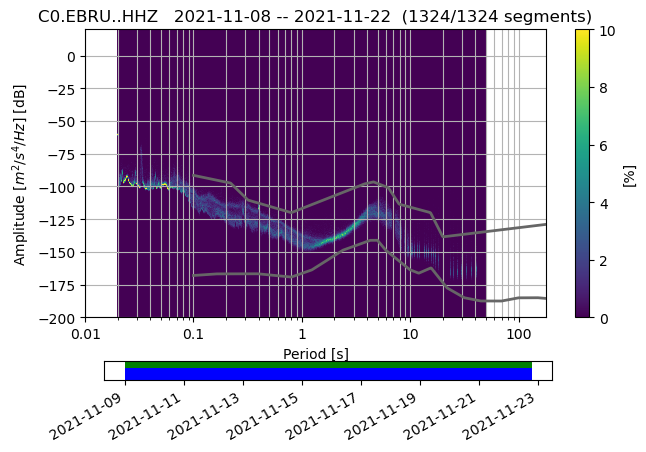

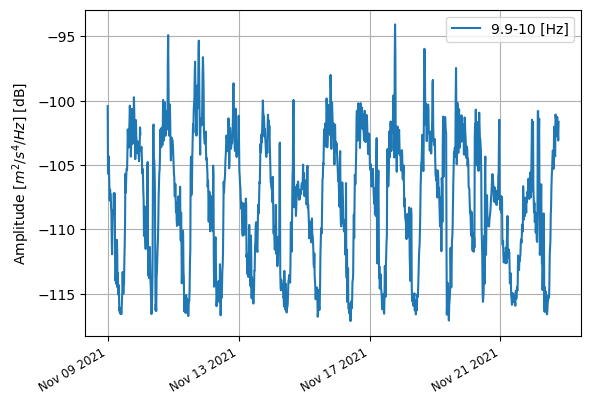

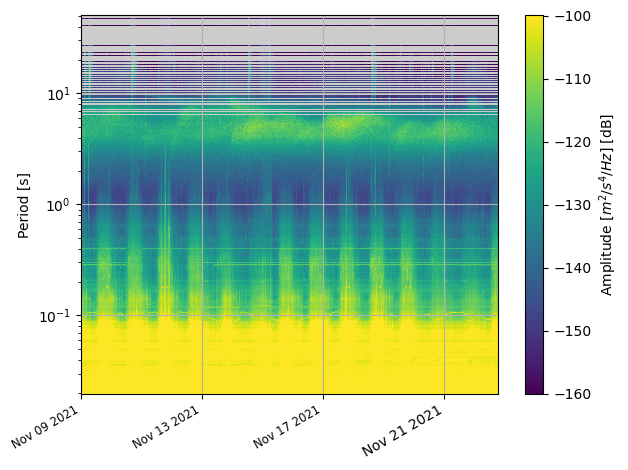

[None]

In [6]:
[ppsd.plot(max_percentage=10) for mseedid, ppsd in ppsds.items()]
[ppsd.plot_temporal(0.10) for mseedid, ppsd in ppsds.items()]
[ppsd.plot_spectrogram(clim=(-160,-100)) for mseedid, ppsd in ppsds.items()]

## Step 7: Process PSDs to extract the RMS(displacement)

This can be done for multiple filters at once (``freqs`` below):

In [7]:
# Define frequency bands of interest:
freqs = [(0.1,1.0),(1.0,20.0),(4.0,14.0),(4.0,20.0)]

displacement_RMS = {}
for mseedid, ppsd in tqdm.tqdm(ppsds.items()):
    ind_times = pd.DatetimeIndex([d.datetime for d in ppsd.current_times_used])
    data = pd.DataFrame(ppsd.psd_values, index=ind_times, columns=1./ppsd.period_bin_centers)
    data = data.sort_index(axis=1)
    displacement_RMS[mseedid] = seismosocialdistancing.df_rms(data, freqs, output="DISP")
    displacement_RMS[mseedid].to_csv("%s.csv" % mseedid)

100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


## Weekday / Time of day Analysis

/home/rdn/projects/basic_data_processing/seismorms/seismosocialdistancing.py:726: FutureWarning: tshift is deprecated and will be removed in a future version. Please use shift instead.
  rs = rs.resample("1D" ).median().tshift(12, "H")


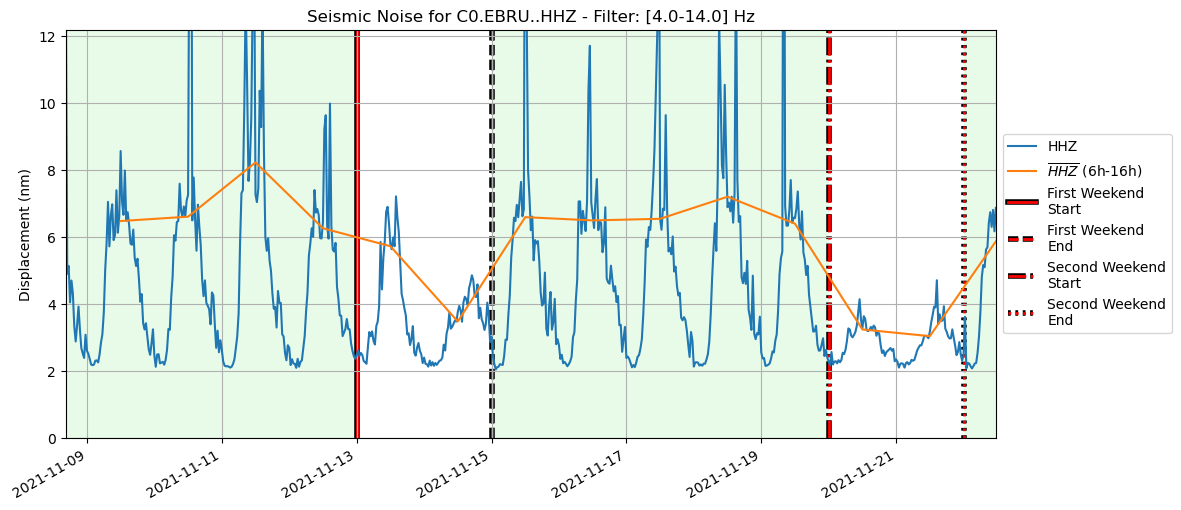

In [8]:
args = {'band':"4.0-14.0",       # might be None or commented ("4.0-14.0" per default) or any of the tupples in freqs
        'time_zone':time_zone,   # required for clockplots
        'sitedesc':sitedesc,     # might be None or commented
        'logo':logo,             # might be None or commented
        'bans':bans,             # might be None or commented
        'save':'./',              # might be None or commented or a path 
        'unit':'nm'
       }
seismosocialdistancing.plot(displacement_RMS,
                            type='timeseries',
                            **args)

## Noise distribution over time of the day  

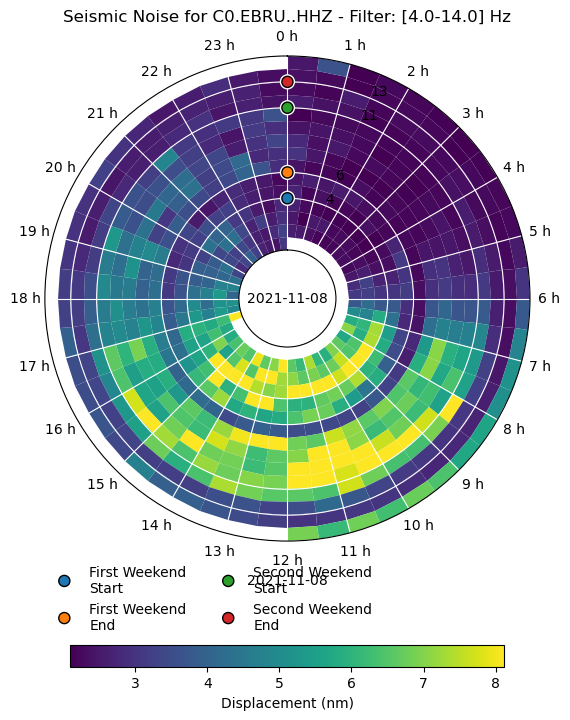

In [9]:
seismosocialdistancing.plot(displacement_RMS,
                            type='clockmaps',
                            **args)

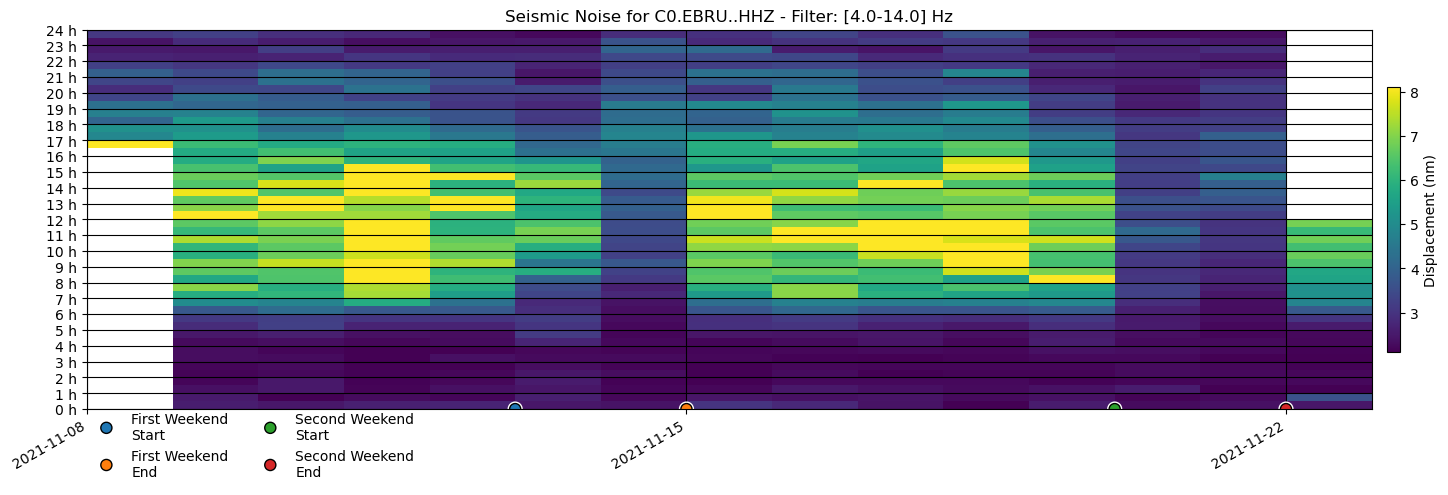

In [10]:
seismosocialdistancing.plot(displacement_RMS,
                            type='gridmaps',
                            **args)

## Temporary code: All your stations' colormapped plot

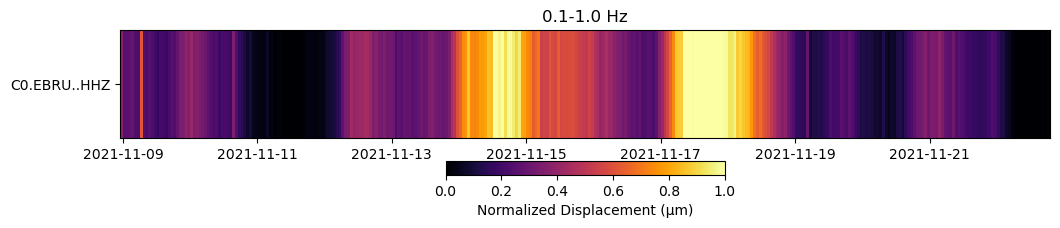

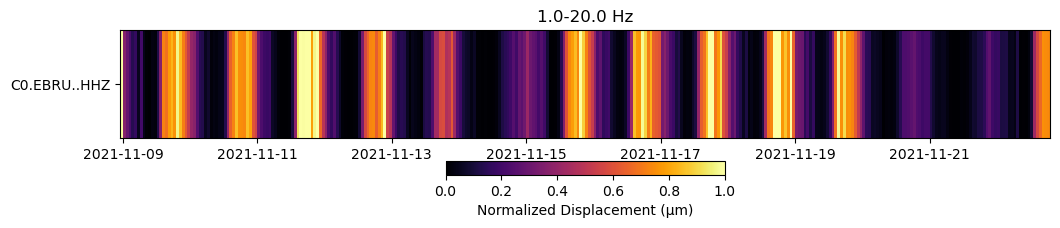

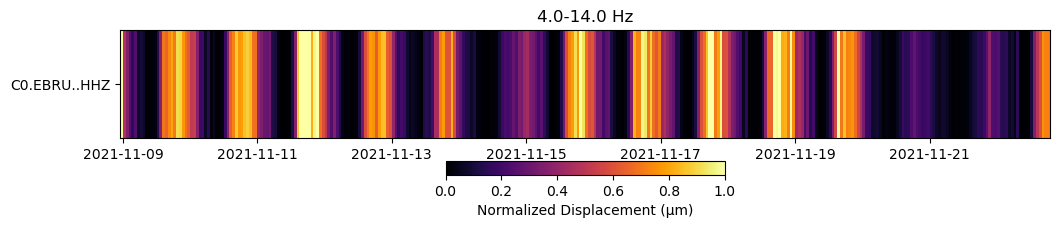

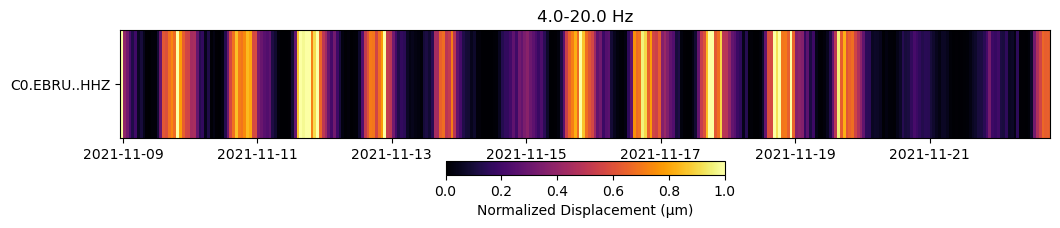

In [11]:
normalize = True
resample_freq = "1H"
clip = (0.05,0.95)

#concatenating in a single dataframe and converting to nm
dRMS2D = pd.concat(displacement_RMS, axis=0) * 1e9
for band in dRMS2D.columns:
    g = dRMS2D.loc[:,band].unstack().T
    g = g.clip(g.quantile(clip[0]),g.quantile(clip[1]),axis=1)
    g = g.resample(resample_freq).median()
    if normalize:
        g -= g.quantile(0.01)
        g /= g.quantile(0.99)
        vmin, vmax = 0, 1
    else:
        vmin = vmax = None
   
    fig, ax = plt.subplots(1,1, figsize=(12,2*len(g.columns)))
    label = '%sDisplacement (µm)' % ["","Normalized "][normalize]

    x = np.append(g.index.values, g.index.shift(1).values[-1])
    y = np.append(g.columns, "")
    plt.pcolormesh(x, y, g.T,  cmap="inferno", vmin=vmin, vmax=vmax)
    plt.colorbar(orientation='horizontal', shrink=0.3).set_label(label)
    pos, l = plt.yticks()
    plt.yticks(np.asarray(pos)+0.5, y)
    plt.margins(0)
    plt.title("%s Hz" % band)
    plt.gca().invert_yaxis()
    plt.show()
